# Sentiment Analysis

In this notebook we will learn how to measure sentiment in text. 

Below is the overview of this notebook.

0. Install required packages (only need to do this the first time we run the notebook)

1. Load corpus of tweets

2. Load sentiment classifier, which in this case is a BERT transformer

3.  Measure tweet sentiment

4. Analyze sentiment of tweets, compare to retweet counts

5. Visualize UMAP transformer embeddings


Below are some cool blogs you can read to learn more about the BERT transformer.

http://jalammar.github.io/illustrated-bert/

https://towardsdatascience.com/deconstructing-bert-distilling-6-patterns-from-100-million-parameters-b49113672f77

https://github.com/jessevig/bertviz

## Install requirements

The pip command lets you install python packages.  We need two packages today.

1) transformers - this lets us use pre-trained transformer models. 

2) umap - this lets you embed high dimensional vectors in low dimensions.

In [1]:
#install transformers
!pip install  transformers 

#install umap
!pip install umap-learn


     |████████████████████████████████| 2.8 MB 12.1 MB/s 
     |████████████████████████████████| 636 kB 44.4 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 895 kB 35.0 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 80 kB 5.6 MB/s 
     |████████████████████████████████| 1.1 MB 30.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=33aafd7384ebdcbc2817ae8c4ebb5409e5918b5cb2db4bc32c499cab4a22fb2a
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=b9f9cb3ea88aef7fee80615bbaaae4b6c8626caa067f756366a60abc2370cb84
  Stored in directory: /

# Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [2]:
!git clone https://github.com/zlisto/sentiment_analysis

import os
os.chdir("sentiment_analysis")

Cloning into 'sentiment_analysis'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 38 (delta 11), reused 28 (delta 6), pack-reused 0
Unpacking objects: 100% (38/38), done.


## Import Packages

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codecs
import umap
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"device ={device}")

device =cuda


# Sentiment Classification with BERT

We will pass the tweets through a pre-trained sentiment classifier with a BERT core.  Then we will plot the tweets with UMAP and color them by their sentiment.  Hopefully the positive and negative are in different regions of the plot.

### Download Pre-Traine Model and Tokenizer

We will download the model and tokenizer from https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment.  This is a pre-trained model in the huggingface library that was trained on product reviews in multiple languages.  The output sentiment is between 1 and 5.

There are many other models on huggingface that you can find here: https://huggingface.co/models?pipeline_tag=text-classification.

We will create a tokenizer for the model called `tokenizer` and create the model itself, which we call `model`.  Every model needs its own tokenizer which tells it how to map text into the proper input vectors.

In [11]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


### Define Sentiment Classifier and Transformer Embedding Function

When we pass text through our transformer model, we get many pieces of data in the output. First, we get the sentiment of the text.  Second, we get the text embedding in the final layer of the transformer.  Remember, inside the transformer we turn the input text into a high dimensional vector. This is the transformer embedding, and it is designed to separate text based on sentiment.


We will create a function called `sentiment_classifier` which takes as input a string `text`, a transformer model called `model`, and a tokenizer called `tokenizer`, and returns the sentiment and embedding of the text.  The raw sentiment output of the model is a probability for each sentiment value.  The function will return the average sentiment based on these probabilities.  


In [7]:
def sentiment_classifier(text,model,tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  #use this line if you want the mean score
    embedding = output.hidden_states[12].detach().numpy().squeeze()[0]
    
    return sentiment, embedding


### Sentiment Classification Example
Now we can test the model on some text.  Feel free to try any text you want here.  Just put your text in the list `Text`.

In [30]:
Text = ["This class is kinda boring, but informative", 
        "This class is awesome", 
        "this class is dope", 
        "this class is stupid",
        "this class is fun",
       "this class is fun!",
       "this class is :(",
       "this class is :)",
]

In [31]:
for text in Text:
    sentiment,embedding = sentiment_classifier(text,model,tokenizer)
    print(f"Text: {text}\nSentiment:{sentiment:.2f}\n")

Text: This class is kinda boring, but informative
Sentiment:3.12

Text: This class is awesome
Sentiment:4.84

Text: this class is dope
Sentiment:2.77

Text: this class is stupid
Sentiment:1.24

Text: this class is fun
Sentiment:4.26

Text: this class is fun!
Sentiment:4.44

Text: this class is :(
Sentiment:3.57

Text: this class is :)
Sentiment:4.29



### Load Tweets 

Load the tweets from the file `"data/tweets_sentiment_embedding.csv"` into a dataframe `df`.  

In [36]:
df = pd.read_csv("data/tweets_sentiment_embedding.csv")

df = df[['screen_name','text','retweet_count']]
ntweets = len(df)
print(f"dataframe has {ntweets} tweets\n")
[print(f"Tweets from {x}") for x in df.screen_name.unique()];


dataframe has 29056 tweets

Tweets from elonmusk
Tweets from MichelleObama
Tweets from BarackObama
Tweets from AOC
Tweets from KingJames
Tweets from KimKardashian
Tweets from mtgreenee
Tweets from nytimes
Tweets from kanyewest
Tweets from JoeBiden


### Calculate Sentiment and Transformer Embedding of Tweets

We use a for loop iterating over the rows in `df` to calculate the sentiment and transformer embedding of each tweet.  We store the sentiment in the list `Sentiment` and embeddings in the list `Embedding`.  We then add the sentiment to a column in `df` and save the resulting dataframe to a file `"data/lec_12_tweets_sentiment_embedding.csv"`.  This may take a long time on your machine unless you have a GPU.



In [17]:
%%time
c = 0
Sentiment = []
Embedding = []
for index,row in df.iterrows():
    c+=1
    if c%1000==0:print(f"Tweet {c}/{len(df_tweets)}")
    sentiment,embedding = sentiment_classifier(row.text,model,tokenizer)
    Sentiment.append(sentiment)
    Embedding.append(embedding)

df['sentiment'] = Sentiment
df.to_csv("data/tweets_sentiment.csv")
df.head()
    

Tweet 1000/5078
Tweet 2000/5078
Tweet 3000/5078
Tweet 4000/5078
Tweet 5000/5078
CPU times: user 14min 20s, sys: 5.17 s, total: 14min 25s
Wall time: 14min 21s


### UMAP Transformer Embedding of Tweets

The tranformer turns the input text into a high dimensional vector.  This is the transformer embedding, and it is designed to separate text based on sentiment.  However, we can't really visualize such a high-dimensional object.  But no worries, UMAP will let us embed this high-dimensional vector into 2 dimensions.  UMAP stands for Uniform Manifold Approximation and Projection for Dimension Reduction.  You can read more about UMAP on its website https://umap-learn.readthedocs.io/en/latest/.

We apply UMAP to the transformer embedding `Embedding` to create the UMAP transformer embedding `umap_bert_embedding`.  Before doing this we have to convert `Embedding` from a list to an array.  Then we save the UMAP embedding values in `df` as `"umap_transformer_x"` and `"umap_transformer_y"`.  The dataframe is saved to the file `"data/lec_12_tweets_sentiment_embedding.csv"`.



In [22]:
%%time

Embedding = np.array(Embedding)
umap_bert_embedding = umap.UMAP(n_components = 2, metric='cosine').fit_transform(Embedding)
df['umap_transformer_x'] = umap_bert_embedding[:,0]
df['umap_transformer_y'] = umap_bert_embedding[:,1]

df.to_csv('data/tweets_sentiment_embedding.csv')

CPU times: user 24 s, sys: 180 ms, total: 24.2 s
Wall time: 14.2 s


# Analyze Tweet Sentiment

### Load Tweets and Sentiment

Once we save the tweet sentiments, the next time we run the notebook we can just load this data instead of recalculating the sentiment.  The sentiment is in the file `"data/tweets_sentiment_embedding.csv"`.

In [42]:
df = pd.read_csv("data/tweets_sentiment_embedding.csv")

print(f"dataframe has {len(df)} tweets")
[print(f"Tweets from {x}") for x in df.screen_name.unique()];
df.sample(n=5)

dataframe has 29056 tweets
Tweets from elonmusk
Tweets from MichelleObama
Tweets from BarackObama
Tweets from AOC
Tweets from KingJames
Tweets from KimKardashian
Tweets from mtgreenee
Tweets from nytimes
Tweets from kanyewest
Tweets from JoeBiden


,Unnamed: 0,screen_name,text,retweet_count,sentiment,umap_transformer_x,umap_transformer_y
11745,11745,KingJames,I CANNOT WAIT!!! @GMC \U0001f440\U0001f4aa\U00...,1985,2.647625,7.864026,2.307560
10555,10555,AOC,"We need real paid sick leave,\nright now,\nfor...",28237,1.376985,9.180632,-0.549610
15509,15509,KimKardashian,I can\u2019t wait to live tweet with you guys ...,190,3.543238,4.838488,3.210625
17130,17130,KimKardashian,The cover of @archdigest is something I have a...,257,3.991591,7.443412,3.281357
26079,235,JoeBiden,I\u2019m forever humbled by the fact that 5.7 ...,2950,2.297024,7.262707,1.557418


### Average User Sentiment

We make a bar plot of the average sentiment of each user.  We do this by grouping `df` by `"screen_name"` and then taking the mean of each group with the `mean` function.  We save this a new dataframe `df_plot` and then use the `barplot` function to make the bar plot.

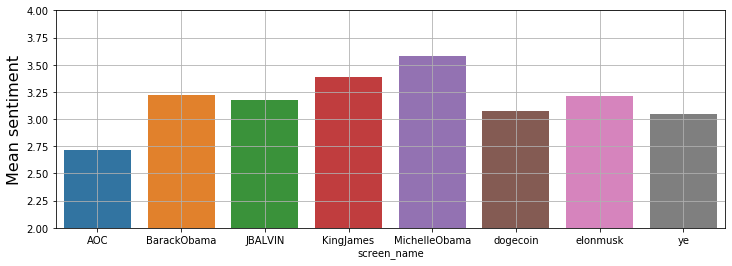

In [ ]:
fig = plt.figure(figsize = (16,6))
sns.barplot(data = df, y= 'sentiment', x = 'screen_name' )
plt.ylim([2,4])
plt.ylabel("Mean sentiment",fontsize = 16)
plt.grid()
plt.ylim([0,5]);
plt.show()

### Sentiment Distribution per User

We can make histograms of the tweet sentiment for each user.  We use a for loop to iterate through each screen name.
We use the `histplot` function to make a histogram of the tweets of each user.  We also add a title to each plot so we know whose tweets they are.

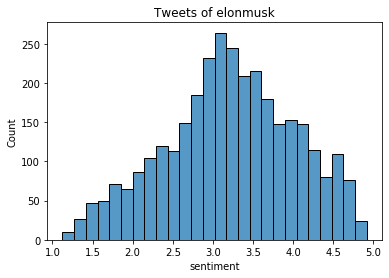

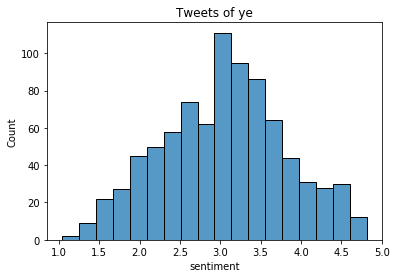

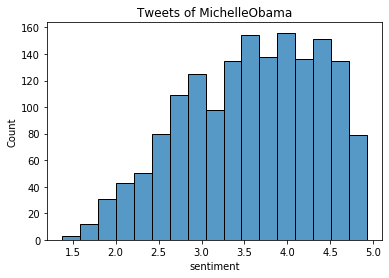

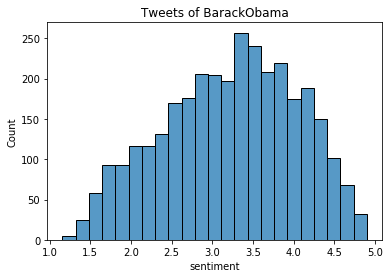

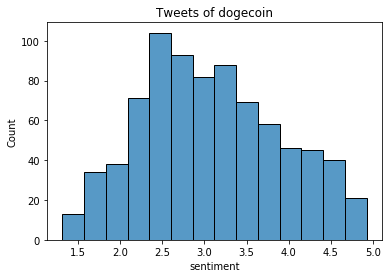

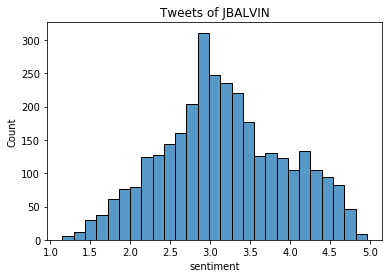

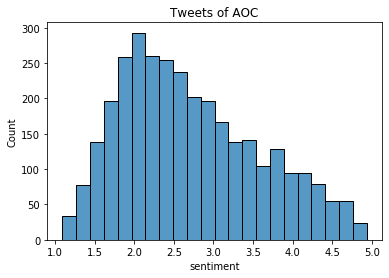

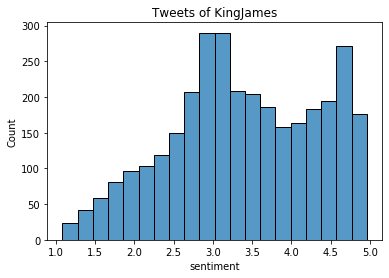

In [ ]:
for screen_name in df.screen_name.unique():
  sns.histplot(data = df[df.screen_name==screen_name], x = 'sentiment')
  plt.title(f"Tweets of {screen_name}", fontsize = 14)
  plt.show()

### Look at Tweets with Extreme Sentiment

We can select tweets of each user with very high or very low sentiment and print them out.  We do this by keeping the rows of `df` with the corresponding screen name, and then using `sort_values` to sort the user's tweets by sentiment.  We set `ascending = True` inside the `for` loop to get the most postive tweets, and set `ascending = False` to get the most negative tweets.  We set `ndisplay` equal to the number of tweets we want to print per user.

To show all the funny Twitter characters, we need to use the `decode` function in the `codecs` module.



In [54]:
ndisplay = 3
print(f"Top {ndisplay} most negative tweets per screen name")
for screen_name in df.screen_name.unique():
  df_display = df[(df.screen_name==screen_name)].sort_values(by = ['sentiment'], 
                                                             ascending=True)
  c = 0
  print(f"\n{screen_name}")
  for index,row in df_display.iterrows():
    c+=1
    text = codecs.decode(row.text, 'unicode_escape')
    print(f"\tsentiment = {row.sentiment:.2f}: {text}")
    if c>=ndisplay:
      break






Top 3 most negative tweets per screen name

elonmusk
	sentiment = 1.12: @Amro_Alzeiq @CNN @GavinNewsom I literally have the receipts!! This is so dumb. 🤣🤣 
	sentiment = 1.14: @flcnhvy @RationalEtienne @chrish7985 @rlyrlysryDave Klippenstein has gone full twitter troll. Big mistake. Never go full troll! 
	sentiment = 1.15: @pesachlattin This is false. I have never introduced either of them to anyone. 

MichelleObama
	sentiment = 1.38: RT @BarackObama: No jump shots. No ferns. No memes. Not this time. I’m going to give it to you straight: If you need health insurance for 2… 
	sentiment = 1.52: And this is just unconscionable at a time when a staggering number of Americans are dying every day from a virus th… https://t.co/aCt2WOQDIf 
	sentiment = 1.59: It’s been over two weeks since the First Lady spoke at #DNC2012 and we’re still fired up: http://t.co/svaBdaR2 

BarackObama
	sentiment = 1.16: Actively ignoring this epidemic is unacceptable. Congress has to act. #DisarmHate https://t.co/n

In [ ]:
ndisplay = 3
print(f"Top {ndisplay} most postive tweets per screen name")
for screen_name in df.screen_name.unique():
    df_display = df[(df.screen_name==screen_name)].sort_values(by = ['sentiment'], 
                                                               ascending = False)
    c=0
    print(f"\n{screen_name}")
    for index,row in df_display.iterrows():
        c+=1
        text = codecs.decode(row.text, 'unicode_escape')
        print(f"\tsentiment = {row.sentiment:.2f}: {text}")
        if c>=ndisplay:break

print("".join('-' * 200))

print(f"Top {ndisplay} Most Negative Tweets per Screen Name")
for screen_name in df.screen_name.unique():
    df_display = df[(df.screen_name==screen_name)].sort_values(by = ['sentiment'], ascending = True)
    c=0
    print(f"\n{screen_name}")
    for index,row in df_display.iterrows():
        c+=1
        text = codecs.decode(row.text, 'unicode_escape')
        print(f"\tsentiment = {row.sentiment:.2f}: {text}")
        if c>=ndisplay:break



Top 3 Most Positive Tweets per Screen Name

elonmusk
	sentiment = 4.92: Such a privilege to work with people I like &amp; respect so much. I feel blessed. 
	sentiment = 4.91: One of the all-time best songs https://t.co/IvI7IOgMAa 
	sentiment = 4.91: @lrocket Thanks for everything you did to help build SpaceX! Some of the best memories ever. 

ye
	sentiment = 4.81: @m0E_tv my PC and I are very happy thank you 
	sentiment = 4.81: Thank you @BeddyFPS for optimizing my pc! Quick and efficient service 
	sentiment = 4.78: @briannasaurus I love you Brianna!! 

MichelleObama
	sentiment = 4.92: Happy 20th anniversary, Barack. Thank you for being an incredible partner, friend, and father every day. I love you! –mo 
	sentiment = 4.92: One of my greatest joys as First Lady was getting to meet so many incredible young people from across the country.… https://t.co/h3Q3vadmWE 
	sentiment = 4.92: So incredibly proud of these students! Everyone at @IPROMISESchool—teachers, staff, and of course those in

### Box Plot of Retweet Count vs Sentiment

To see this correlation of extreme sentiment and retweet count, we can make a box plot. The box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.  More details on the `boxplot` function can be found here: https://seaborn.pydata.org/generated/seaborn.boxplot.html

 We first create a column called `star` that rounds the sentiment to the nearest integer.  Then we can make a boxplot of the retweet count versus the tweet star sentiment.  We will have to limit the y-axis in order to see the pattern clearly.  We set the maximum value on the y-axis equal to `ymax`, which we set to be an upper quantile of the retweet count.

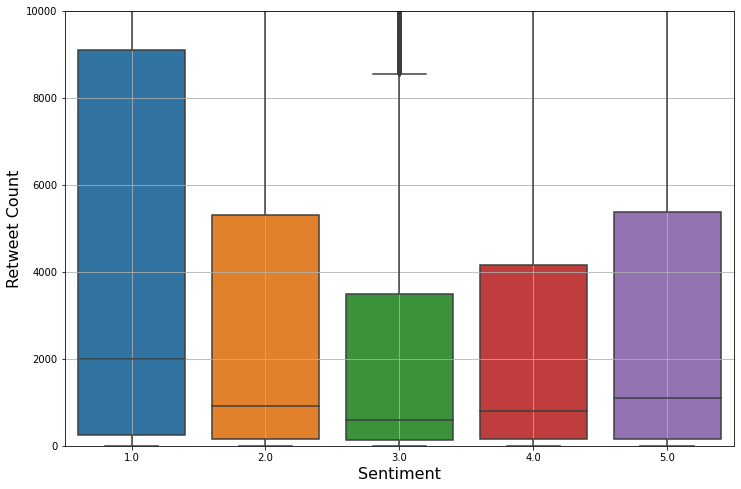

In [58]:
df['star'] = df.sentiment.round()

fig = plt.figure(figsize = (12,8))
sns.boxplot(data = df, x= "star", y = 'retweet_count')
ymax = df.retweet_count.quantile(0.95)
plt.ylim([0,1e4])
plt.xlabel("Sentiment", fontsize = 16)
plt.ylabel("Retweet Count", fontsize = 16)
plt.grid()
plt.show()




In [ ]:
df['star'] = df.sentiment.round()

fig = plt.figure(figsize = (12,8))
sns.boxplot(data=df, x="star", y="retweet_count")
ymax = df.retweet_count.quantile(0.95)
plt.ylim([0,ymax])
plt.xlabel("Sentiment", fontsize = 16)
plt.ylabel("Retweet Count", fontsize = 16)
plt.grid()
plt.show()

### Box Plot per User

We can also look at a boxplot for each individual user.  

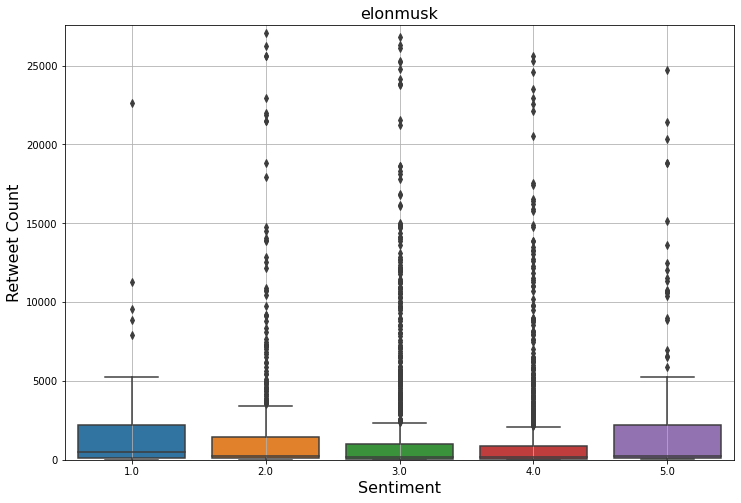

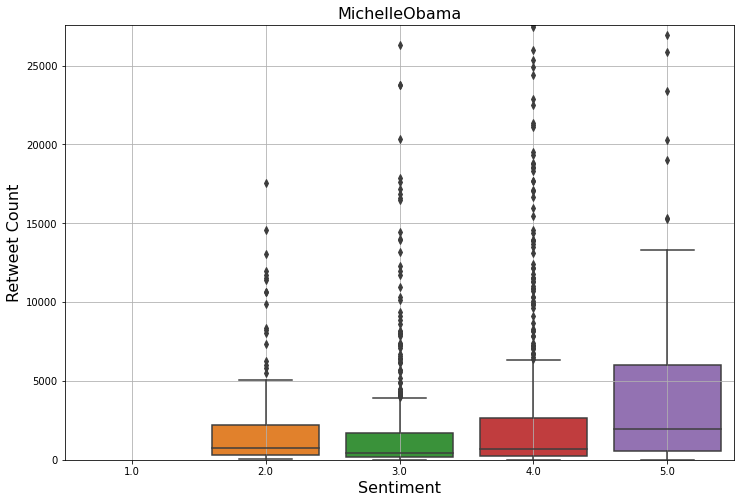

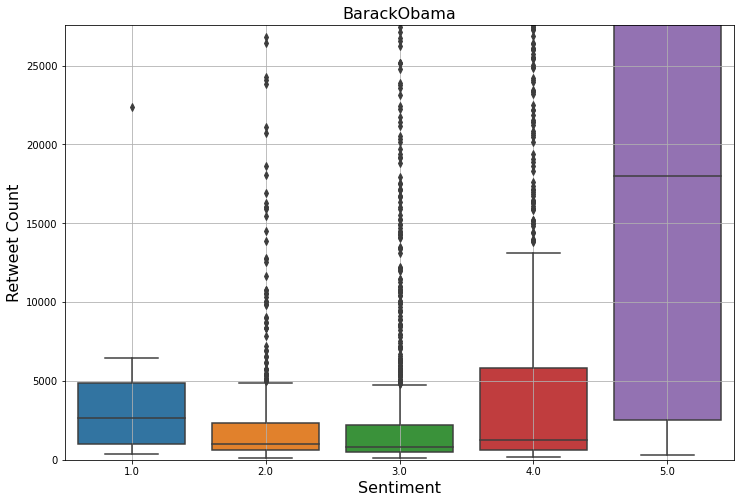

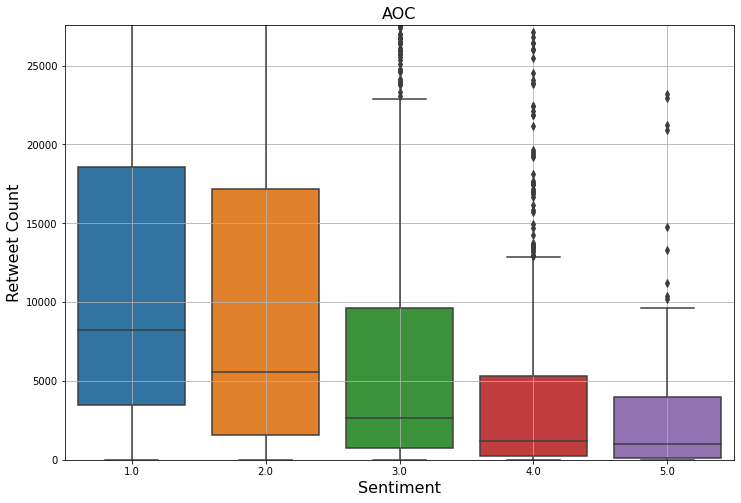

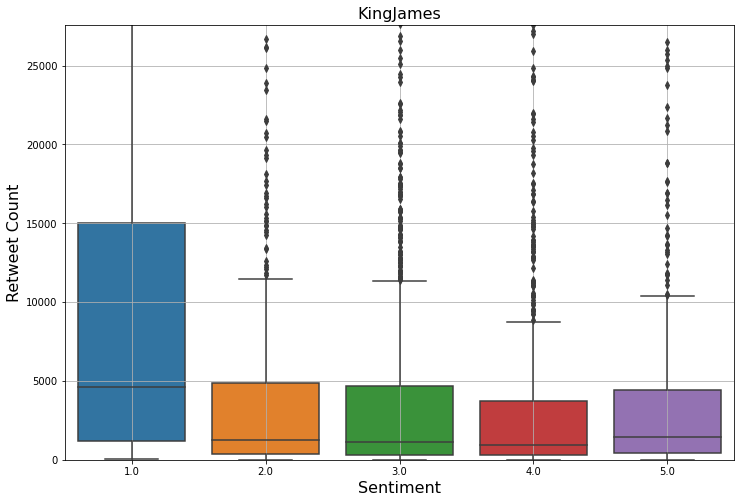

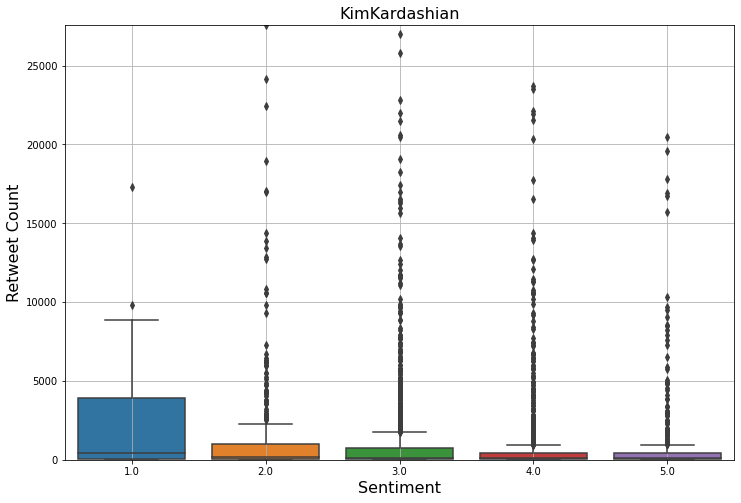

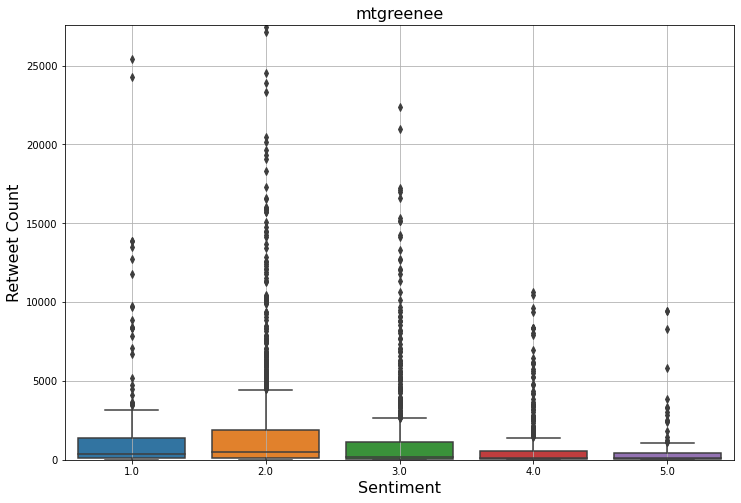

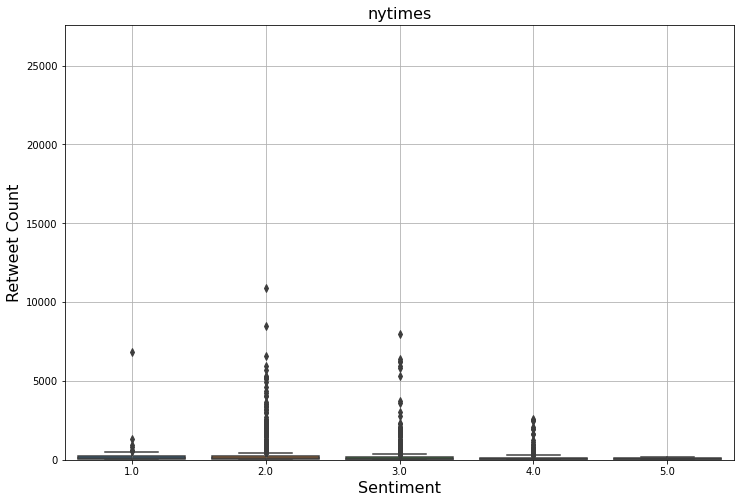

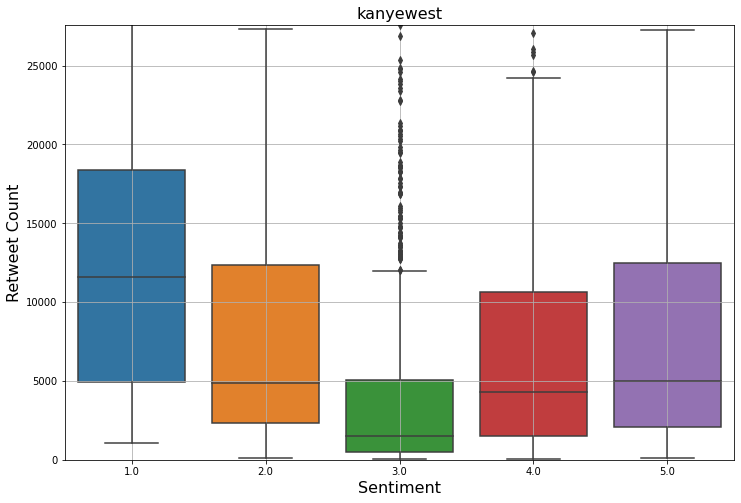

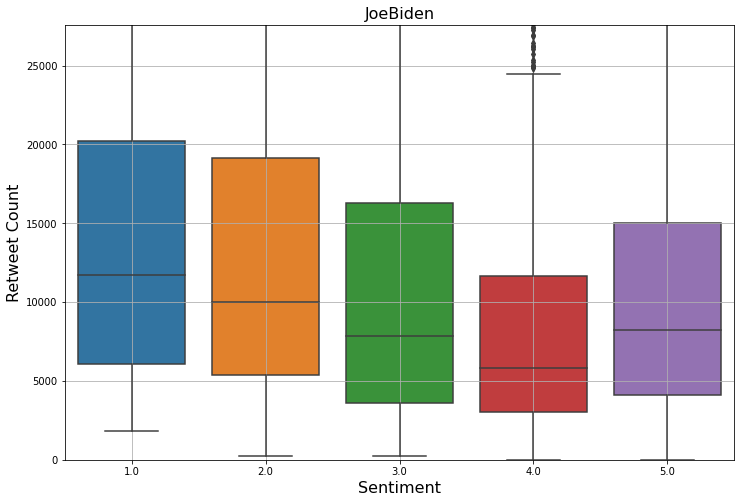

In [71]:
for screen_name in df.screen_name.unique():
  fig = plt.figure(figsize = (12,8))
  sns.boxplot(data = df[df.screen_name==screen_name], x= "star", y = 'retweet_count')
  ymax = df.retweet_count.quantile(0.95)
  plt.ylim([0,ymax])
  plt.xlabel("Sentiment", fontsize = 16)
  plt.ylabel("Retweet Count", fontsize = 16)
  plt.title(f"{screen_name}", fontsize = 16)

  plt.grid()
  plt.show()




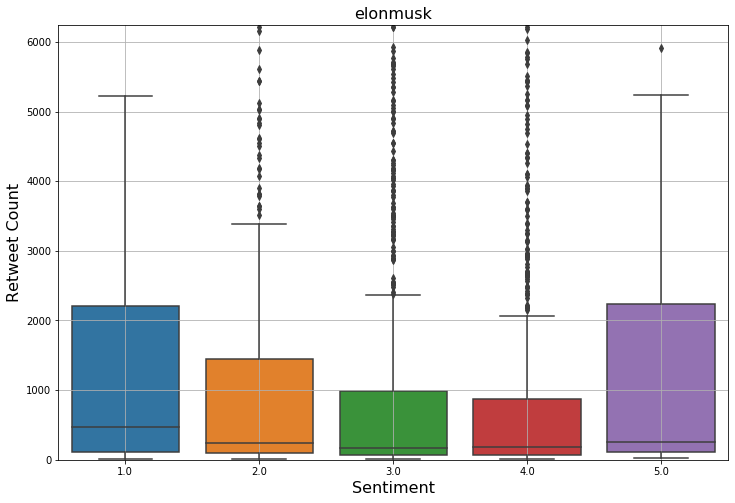

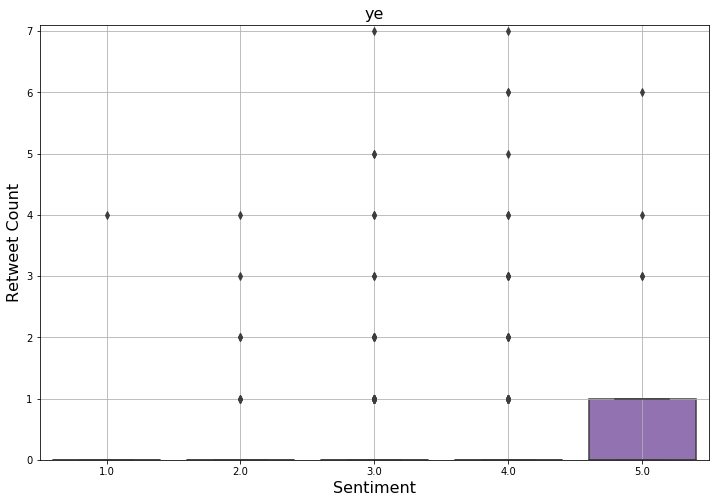

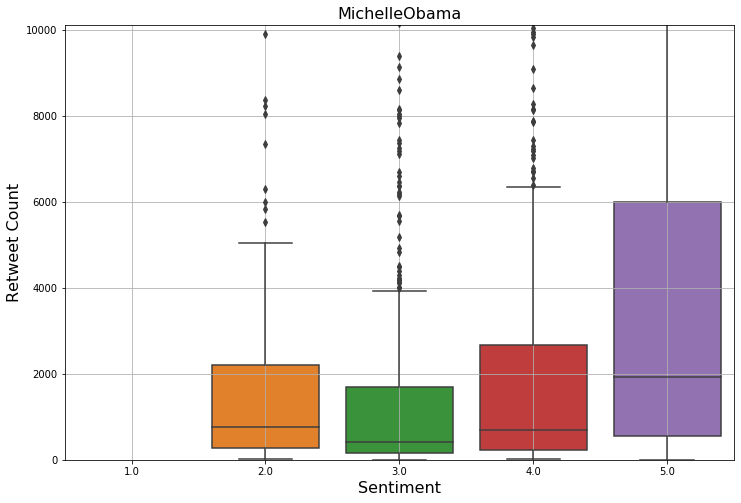

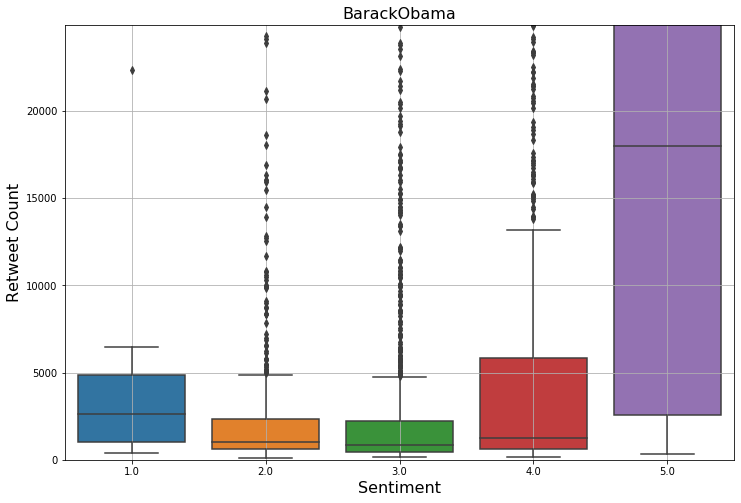

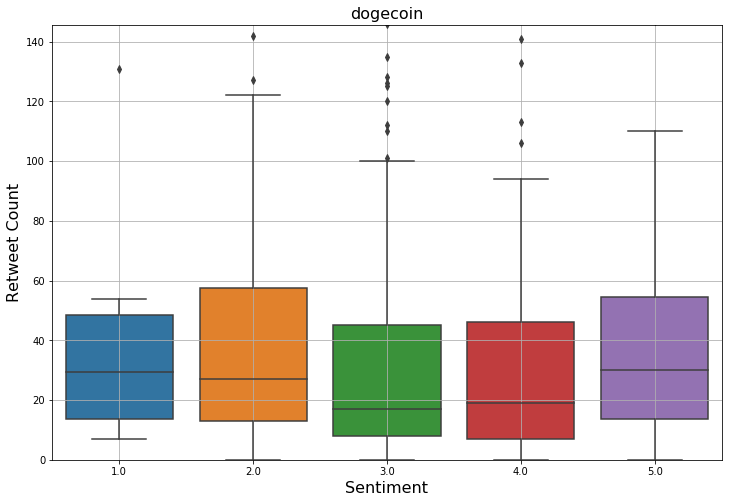

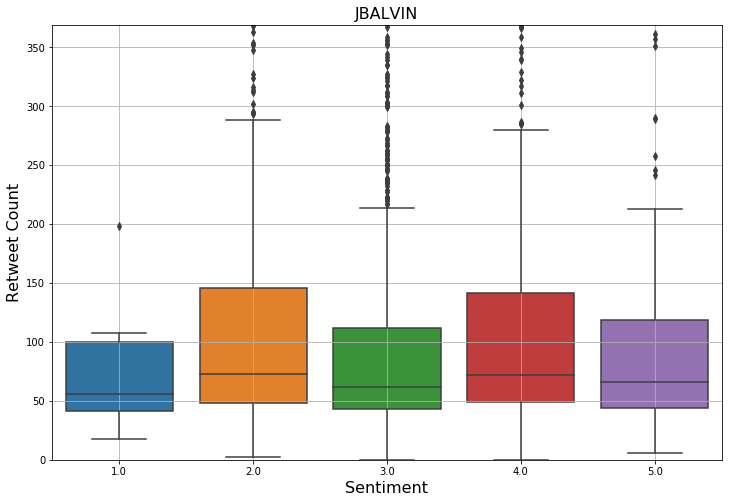

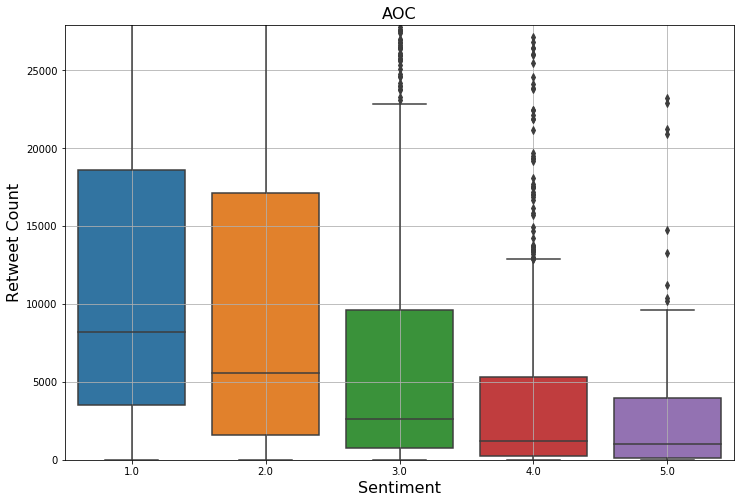

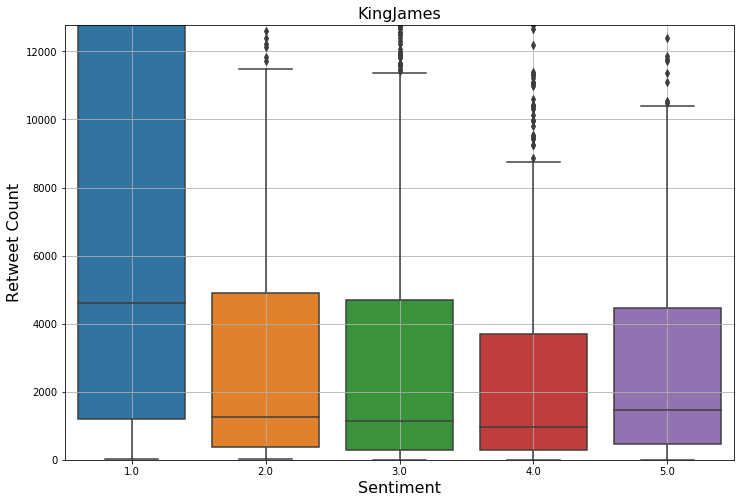

In [ ]:
for screen_name in df.screen_name.unique():
    fig = plt.figure(figsize = (12,8))
    df_plot = df[df.screen_name==screen_name]
    ax = sns.boxplot(data=df_plot, x="star", y="retweet_count")
    ymax = df_plot.retweet_count.quantile(q=0.9)
    plt.ylim([0,ymax])
    plt.xlabel("Sentiment", fontsize = 16)
    plt.ylabel("Retweet Count", fontsize = 16)
    plt.title(f"{screen_name}", fontsize = 16)
    plt.grid()
    plt.show()

# Visualize Transformer Embedding

Now we will visulize the transformer embeddings using UMAP to see how the sentiment is distributed.

### Scatter Plot of UMAP Transformer Tweet Embeddings

We can make a scatter plot of the UMAP transformer embeddings of the tweets.  We will color the data points by the user screen name.  We will also make another plot next to this plot where we color the data points by sentiment.  You set the column for the datapoint color with the `hue` parameter.  You can choose a color palette with the `palette` parameter.  There are many palettes you can choose from, but for discrete values like `"screen_name"` use the `"bright"` palette and for continous values like `"sentiment"` use the `"vlag"` palette.  Of course feel free to try other palettes. A complete list can be found here: https://seaborn.pydata.org/tutorial/color_palettes.html


In [ ]:
for screen_name in df.screen_name.unique():
  fig = plt.figure(figsize = (8,8))
  sns.scatterplot(data=df[df.screen_name == screen_name], 
                  x="umap_transformer_x", 
                  y="umap_transformer_y", 
                  hue="sentiment", 
                  palette="vlag", s=15)
  plt.title(f"UMAP Transformer Embedding for {screen_name}")
  plt.show()
